# Методы первой необходимости

In [1]:
import os
os.environ['HF_HOME'] = 'D:\\HuggingFace'
os.environ['TRANSFORMERS_CACHE'] = os.environ['HF_HOME']
os.environ['HUGGINGFACE_HUB_CACHE'] = os.environ['HF_HOME'] 

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import pipeline
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Предобработка текстов в pdf и создание датасета

In [3]:
import PyPDF2
import pathlib

In [4]:
clean_data = pd.DataFrame({"Education": [], "Art": [], "Space": [], "Sport": [], "Chemical": []})

In [27]:
def process_info(file):
    with open(file, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        text = ''.join([page.extract_text() for page in reader.pages])
    # Служебная информация
    text = re.sub(r'ISSN\s+\d{4}-\d{3,4}[^\n]*', '', text)
    text = re.sub(r'\d{4};\d{2}\(\d+\):\d+–\d+', '', text)

    # Авторы
    text = re.sub(r'[А-ЯЁ][а-яё]+\s+[А-ЯЁ][\.\s]+\s*[А-ЯЁ][\.\s]*', '', text)
    text = re.sub(r'[А-ЯЁ][а-яё]+\s+[А-ЯЁ][а-яё]+\s+[А-ЯЁ][\.\s]+\s*[А-ЯЁ][\.\s]*', '', text)
    text = re.sub(r'\d+[\s\w\.,–-]+(университет|институт|академия|центр)[^\n]*', '', text)

    # Сноски в квадратных скобках
    text = re.sub(r'\[\d+\]', '', text)  # [1], [2]
    text = re.sub(r'\[\d+[,-]\d+\]', '', text)  # [1-3], [4,5]
    text = re.sub(r'\[[A-Za-z]+\d*\]', '', text)  # [A1], [B]
    
    # email
    text = re.sub(r'\S+@\S+', '', text)
    
    # английские разделы 
    text = re.sub(r'Abstract[^\n]*[\s\S]*?(?=\n[А-ЯЁ]|$)', '', text)
    text = re.sub(r'Keywords[^\n]*[\s\S]*?(?=\n[А-ЯЁ]|$)', '', text)
    text = re.sub(r'For citation[^\n]*[\s\S]*?(?=\n[А-ЯЁ]|$)', '', text)
    
    # ссылки
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'DOI:\s*\S+', '', text)
    
    # библиография
    text = re.sub(r'Список\s+источников[\s\S]*', '', text)
    text = re.sub(r'References[\s\S]*', '', text)
    
    # спец.символы
    text = text.replace('\xa0', ' ').replace('•', '')
    text = re.sub(r'-\s+', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'•\s*\n', '', text)
    
    # оставшиеся английские фрагменты
    text = re.sub(r'(?:[A-Za-z-]+\s){3,}[A-Za-z-]*', '', text)
    
    return text

## Тексты образования

In [28]:
books = pathlib.Path("D:/ПРОГА/Проектики/Github/Electronic_library/dataset/Образование")
files_to_process = []
for book in books.iterdir():
    files_to_process.append(str(book))

clean_files = []
for file in files_to_process:
    clean_files.append(process_info(file))

clean_data['Education'] = clean_files

## Тексты спорта

In [29]:
books = pathlib.Path("D:/ПРОГА/Проектики/Github/Electronic_library/dataset/Спорт")
files_to_process = []
for book in books.iterdir():
    files_to_process.append(str(book))

clean_files = []
for file in files_to_process:
    clean_files.append(process_info(file))

clean_data['Sport'] = clean_files

## Тексты космоса

In [30]:
books = pathlib.Path("D:/ПРОГА/Проектики/Github/Electronic_library/dataset/Космос")
files_to_process = []
for book in books.iterdir():
    files_to_process.append(str(book))

clean_files = []
for file in files_to_process:
    clean_files.append(process_info(file))

clean_data['Space'] = clean_files

## Тексты химии

In [31]:
books = pathlib.Path("D:/ПРОГА/Проектики/Github/Electronic_library/dataset/Химия")
files_to_process = []
for book in books.iterdir():
    files_to_process.append(str(book))

clean_files = []
for file in files_to_process:
    clean_files.append(process_info(file))

clean_data['Chemical'] = clean_files

## Тексты искусствоведения

In [32]:
books = pathlib.Path("D:/ПРОГА/Проектики/Github/Electronic_library/dataset/Искусствоведение")
files_to_process = []
for book in books.iterdir():
    files_to_process.append(str(book))

clean_files = []
for file in files_to_process:
    clean_files.append(process_info(file))

clean_data['Art'] = clean_files

In [33]:
clean_data.shape

(20, 5)

## Создание датасета

In [3]:
clean_data.to_csv('clean_data.csv', sep=',', index=False, encoding='utf-8-sig')

NameError: name 'clean_data' is not defined

# Построение модели

## Загрузка данных

In [3]:
data = pd.read_csv('clean_data.csv')

In [5]:
data.head()

,Education,Art,Space,Sport,Chemical
0,ПЕДАГОГИЧЕСКИЙ ОПЫТ / PEDAGOGICAL EXPERIENCE г...,8 РОССИЙСКИХ ЦЕННОСТЕЙ В КОНКРЕТНОИСТОРИЧЕСКОМ...,Солнечно -земная физика. 2024. Т. 10. № 4 Soln...,Ученые записки университета имени П.Ф. Лесгафт...,ХИМИЯ РАСТИТЕЛЬНОГО СЫРЬЯ . 2025 . №1. С. 106–...
1,"ИНФОРМАТИЗАЦИЯ ОБРАЗОВАНИЯ / г. Москва, Россия...",110 БАУХАУСА И ИХ ВЛИЯНИЕ НА ТЕОРИЮ АРХИТЕКТУР...,Солнечно -земная физика. 2025. Т. 11. № 1 Soln...,Ученые записки университета имени П.Ф. Лесгафт...,ХИМИЯ РАСТИТЕЛЬНОГО СЫРЬЯ . 2025. №1. С. 188–1...
2,ИНФОРМАТИЗАЦИЯ ОБРАЗОВАНИЯ / Аннотация В повыш...,117 ⇒ Художественная культура. ЭстетикаТ ЕАТРА...,Солнечно -земная физика. 2025. Т. 11. № 1 Soln...,Ученые записки университета имени П.Ф. Лесгафт...,ХИМИЯ РАСТИТЕЛЬНОГО СЫРЬЯ . 2025. №1. С. 197–2...
3,ИНФОРМАТИЗАЦИЯ ОБРАЗОВАНИЯ / Аннотация В стать...,"124 ДРАМАТУРГИИ ТЕЛЕСЕРИАЛА УДК 801 Химки, Мос...",Солнечно -земная физика. 2025. Т. 11. № 1 Soln...,Ученые записки университета имени П.Ф. Лесгафт...,ХИМИЯ РАСТИТЕЛЬНОГО СЫРЬЯ . 2025. №1. С. 208–2...
4,ПЕДАГОГИЧЕСКИЙ ОПЫТ / PEDAGOGICAL EXPERIENCE А...,132 В ТЕАТРАЛЬНЫХ ОПЫТАХ А. ВАСИЛЬЕВА УДК 740 ...,Солнечно -земная физика. 2025. Т. 11. № 1 Soln...,Ученые записки университета имени П.Ф. Лесгафт...,ХИМИЯ РАСТИТЕЛЬНОГО СЫРЬЯ . 2025. №1. С. 215–2...


## Загрузка модели с Hugging Face

In [4]:
pipe = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", hypothesis_template="Определи тему научной статьи '{}'", disable_hf_device_logging=True)

## Разделение текста на части

In [5]:
from nltk import sent_tokenize

In [6]:
def chunk_text(text, window_size=3, overlap=1):
    sentences = sent_tokenize(text)
    chunks = []
    for i in range(0, len(sentences), window_size-overlap):
        chunks.append(" ".join(sentences[i:i+window_size]))
    return chunks

In [9]:
chunks = chunk_text(data['Education'][0])

In [10]:
chunks[0]

'ПЕДАГОГИЧЕСКИЙ ОПЫТ / PEDAGOGICAL EXPERIENCE г. Москва, Россия Аннотация Подготовка востребованных на рынке труда специалистов в области информационных технологий (в том числе специалистов по веб-разработке) является одной из важнейших задач высшего образования в условиях цифровизации всех сфер экономики и жизни общества. Для успешного решения этой задачи необходимо тесное взаимодействие вузов и работодателей на всех этапах реализации основных профессиональных образовательных программ: от их создания до оценки сформированности профессиональных компетенций. Статья посвящена актуальной проблеме выбора и проектирования эффективных средств оценивания профессиональных компетенций обучающихся ИТ-направлений в рамках расширенной подготовки в области веб-разработки.'

## Проверка модели на частях

In [7]:
classes = ['Education', 'Art', 'Space', 'Sport', 'Chemical']

In [8]:
def get_pred(query):
    answer = pipe(query, classes, multi_label=False)
    return [answer['labels'], answer['scores']]

In [60]:
print(get_pred(chunks[0]))

[['Education', 'Art', 'Space', 'Sport', 'Chemical'], [0.9758127927780151, 0.00766792194917798, 0.007569583132863045, 0.00525266258046031, 0.0036970695946365595]]


In [61]:
print(get_pred(chunks[1]))

[['Education', 'Art', 'Space', 'Sport', 'Chemical'], [0.9370293021202087, 0.0210417527705431, 0.020402079448103905, 0.014597942121326923, 0.006928957533091307]]


In [62]:
print(get_pred(chunks[2]))

[['Education', 'Space', 'Art', 'Chemical', 'Sport'], [0.5185869932174683, 0.166321262717247, 0.1530447006225586, 0.08969689905643463, 0.07235012203454971]]


In [76]:
print(get_pred(chunks[3]))

[['Education', 'Art', 'Sport', 'Chemical', 'Space'], [0.977515697479248, 0.006754819303750992, 0.00572081608697772, 0.005458444822579622, 0.004550295881927013]]


In [9]:
from collections import defaultdict

def aggregate(document):
    # Делим документ
    chunks = chunk_text(document)

    # Предсказываем каждую часть
    preds = []
    for chun in chunks:
        preds.append(get_pred(chun))
        
    # Считаем взвешенную метрику
    scores = defaultdict(float)
    for pred in preds:
        for label, score in zip(pred[0], pred[1]):
            scores[label] += score

    return max(scores, key=scores.get)

In [18]:
# Засекаем начальное время
start_time = time.time()

print(aggregate(data['Education'][0]))

# Засекаем конечное время и вычисляем разницу
end_time = time.time()
execution_time = end_time - start_time

print(f"Код выполнялся {execution_time:.4f} секунд")

Education
Код выполнялся 446.1664 секунд


## Предсказание класса на научных статьях

In [10]:
predictions = pd.DataFrame()

**Предсказания проделываются на Kaggle, так как там значительно быстрее на GPU**

In [19]:
import time

# Засекаем начальное время
start_time = time.time()

education = []
art = []
sport = []
chemical = []
space = []
for i in range(20):
    education.append(aggregate(data['Education'][i]))
    art.append(aggregate(data['Art'][i]))
    sport.append(aggregate(data['Sport'][i]))
    chemical.append(aggregate(data['Chemical'][i]))
    space.append(aggregate(data['Space'][i]))


    print(f'{i} iteration')
    
predictions['Education'] = education
predictions['Art'] = art
predictions['Sport'] = sport
predictions['Chemical'] = chemical
predictions['Space'] = space

# Засекаем конечное время и вычисляем разницу
end_time = time.time()
execution_time = end_time - start_time

print(f"Код выполнялся {execution_time:.4f} секунд")

## Загрузка предсказаний с Kaggle

In [14]:
preds = pd.read_csv('preds.csv').drop('Unnamed: 0', axis=1)

In [16]:
preds

,Education,Art,Sport,Chemical,Space
0,Education,Art,Sport,Chemical,Space
1,Education,Art,Sport,Chemical,Space
2,Education,Art,Sport,Chemical,Space
3,Education,Art,Sport,Chemical,Space
4,Education,Art,Sport,Chemical,Space
5,Education,Art,Sport,Chemical,Space
6,Education,Education,Sport,Chemical,Space
7,Education,Education,Sport,Chemical,Space
8,Education,Art,Sport,Chemical,Space
9,Education,Education,Sport,Chemical,Space


# Вычисление метрик

In [27]:
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

In [25]:
y_true = 20 * ['Education'] + 20 * ['Art'] + 20 * ['Sport'] + 20 * ['Chemical'] + 20 * ['Space']
predictions = pd.concat([preds['Education'], preds['Art'], preds['Sport'], preds['Chemical'], preds['Space']], ignore_index=True)
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

         Art       0.88      0.70      0.78        20
    Chemical       1.00      1.00      1.00        20
   Education       0.73      0.95      0.83        20
       Space       1.00      1.00      1.00        20
       Sport       1.00      0.90      0.95        20

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



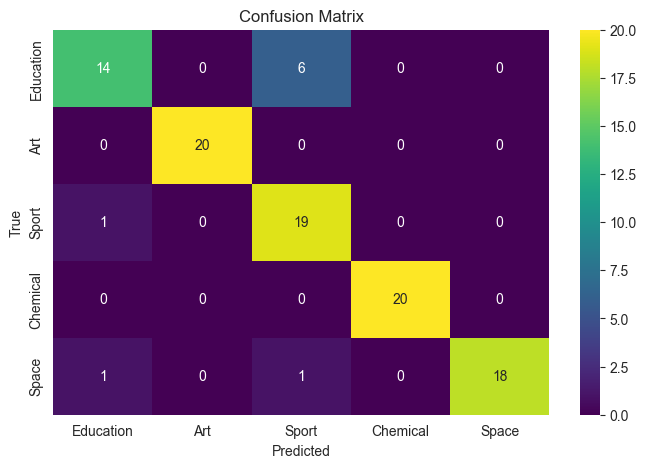

In [32]:
plt.figure(figsize=(8, 5))

cm = confusion_matrix(y_true, predictions, labels=['Education', 'Art', 'Sport', 'Chemical', 'Space'])
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
            xticklabels=preds.columns, 
            yticklabels=preds.columns
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix');

In [33]:
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_true, predictions):.2f}")

Accuracy: 0.91


In [35]:
predictions.head(20)

0     Education
1     Education
2     Education
3     Education
4     Education
5     Education
6     Education
7     Education
8     Education
9     Education
10    Education
11    Education
12    Education
13    Education
14    Education
15    Education
16    Education
17    Education
18          Art
19    Education
dtype: object